In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

# Define the image size and batch size
img_size = (40, 40)
batch_size = 32

# Path to your datasets folder
data_dir = "/kaggle/input/test-and-train/train/None_set"
test_dir = "/kaggle/input/test-and-train/test/test_set"

2024-03-05 05:38:58.080426: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 05:38:58.080514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 05:38:58.245941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    color_mode='grayscale',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    color_mode='grayscale',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

Found 21275 files belonging to 9 classes.
Using 17020 files for training.
Found 21275 files belonging to 9 classes.
Using 4255 files for validation.


In [3]:
# Inspect the class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print('Class names:', class_names)
print('Number of classes:', num_classes)

# List of pre-trained models
pretrained_models = [DenseNet201,EfficientNetB0]

# Dictionary to store model names and their accuracies
model_accuracies = {}

# Dictionary to store model histories
model_histories = {}

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', 'None']
Number of classes: 9


In [ ]:
for model_class in pretrained_models:
    # Load the pre-trained model
    base_model = model_class(weights='imagenet', include_top=False, input_shape=(40, 40, 3))

    # Freeze the weights of the base model
    base_model.trainable = False

    # Add custom classification head
    inputs = Input(shape=(40, 40, 1))
    x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])  # Replicating grayscale channel to 3 channels
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Combine base model and custom head
    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Fitting the model into training data
    #history = model.fit(train_ds, validation_data=val_ds, epochs=30, verbose=0)
    history = model.fit(train_ds, validation_data=val_ds, epochs=30)

    # Evaluating the model
    _, train_acc = model.evaluate(train_ds, verbose=0)
    _, val_acc = model.evaluate(val_ds, verbose=0)

    print(f'Model: {model_class.__name__}')
    print(f'Training Accuracy: {(train_acc * 100):.2f}%\nValidation Accuracy: {(val_acc * 100):.2f}%\n')

    # Store the accuracies
    model_accuracies[model_class.__name__] = (train_acc, val_acc)

    # Store the history
    model_histories[model_class.__name__] = history

In [20]:
# CNN_Model_1 accuracy & loss during training & validation

train_accuracy = [0.6746, 0.9141, 0.9486, 0.9635, 0.9677, 0.9777, 0.9784, 0.9781, 0.9794, 0.9827,
                  0.986, 0.9868, 0.9858, 0.9868, 0.9889, 0.9877, 0.9898, 0.9891, 0.9882, 0.9922,
                  0.9942, 0.9907, 0.9934, 0.9903, 0.9918, 0.9945, 0.9934, 0.9949, 0.9904, 0.9943]

validation_accuracy = [0.851, 0.9159, 0.9377, 0.9584, 0.9565, 0.9561, 0.9596, 0.9579, 0.9652, 0.9619,
                       0.9619, 0.9725, 0.9596, 0.9643, 0.9459, 0.9626, 0.9687, 0.9683, 0.9709, 0.9727,
                       0.9765, 0.9739, 0.9739, 0.9699, 0.9741, 0.9744, 0.9772, 0.9767, 0.9687, 0.973]

# -------------------------------------------------------------------------------------------------------------

train_loss = [1.1657, 0.2925, 0.1768, 0.1217, 0.1009, 0.0736, 0.0711, 0.0694, 0.0677,
              0.0609, 0.0494, 0.0432, 0.0462, 0.0457, 0.0408, 0.0426, 0.0385, 0.0464,
              0.0440, 0.0295, 0.0229, 0.0339, 0.0210, 0.0348, 0.0336, 0.0224, 0.0281,
              0.0179, 0.0374, 0.0241]

validation_loss = [0.4708, 0.2609, 0.2089, 0.1633, 0.1613, 0.1748, 0.1559, 0.1764, 0.1515,
                   0.1649, 0.1830, 0.1268, 0.1783, 0.2006, 0.3437, 0.1913, 0.1845, 0.2056,
                   0.1516, 0.1721, 0.1548, 0.1652, 0.1863, 0.1936, 0.2085, 0.1953, 0.1612,
                   0.1954, 0.2265, 0.1759]

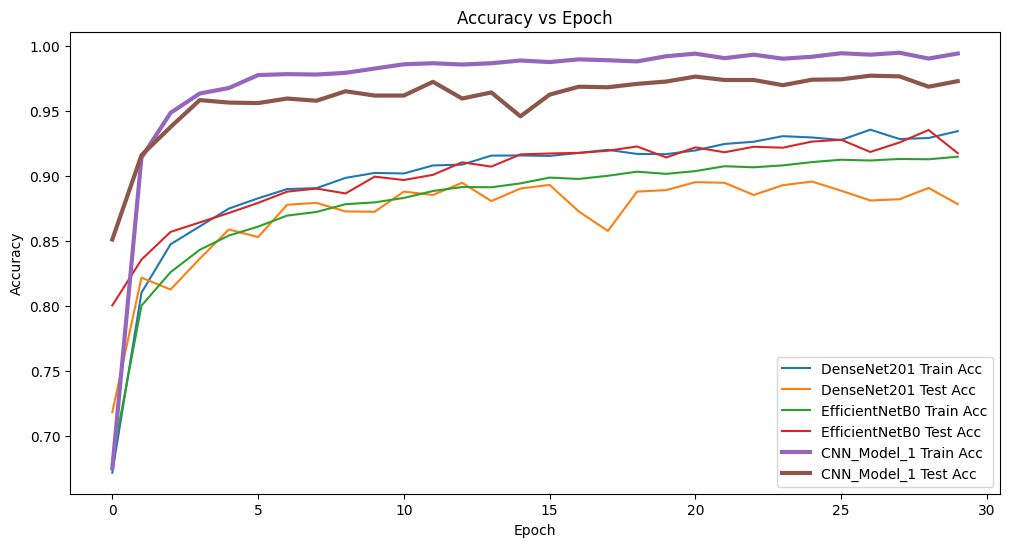

In [21]:
# Plotting accuracy vs epoch
plt.figure(figsize=(12, 6))
for model_name, history in model_histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Acc')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Test Acc')

# Plotting CNN_Model_1 train & valodation accuracy
epochs = range(1, 31)  # 30 epochs
plt.plot(train_accuracy, label='CNN_Model_1 Train Acc', linewidth=3)
plt.plot(validation_accuracy,  label='CNN_Model_1 Test Acc', linewidth=3)

plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

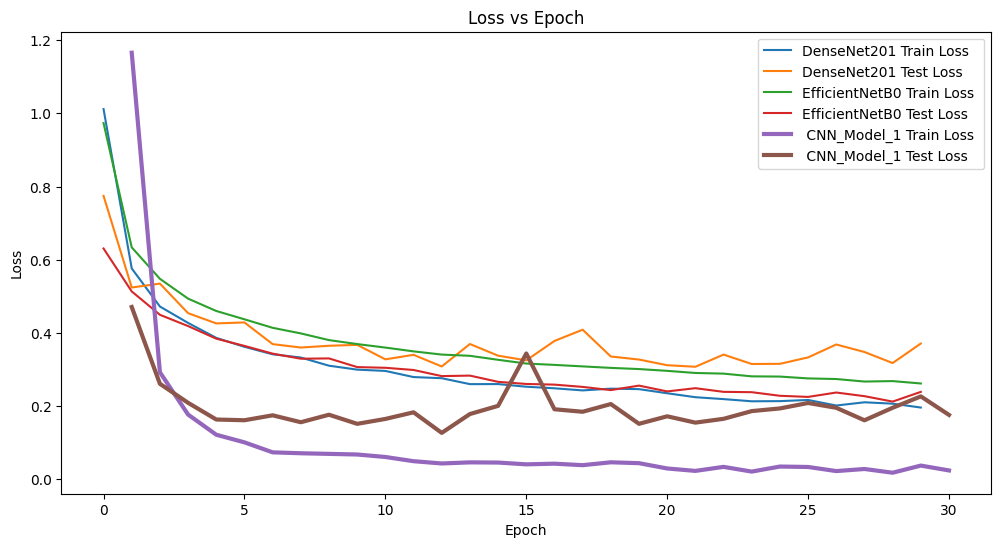

In [22]:
# Plot loss vs epoch
plt.figure(figsize=(12, 6))
for model_name, history in model_histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Test Loss')

# Plot cnn model train & valodation loss
plt.plot(epochs, train_loss,  label=' CNN_Model_1 Train Loss ',linewidth=3)
plt.plot(epochs, validation_loss,  label=' CNN_Model_1 Test Loss ',linewidth=3)

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# DenseNet201

DenseNet201_acc = [0.6650998592376709, 0.8057579398155212, 0.8424206972122192, 0.8605170249938965, 0.8746768236160278, 0.8823736906051636, 0.8902467489242554, 0.890423059463501, 0.8980610966682434, 0.9018213748931885, 0.9026439189910889, 0.9077555537223816, 0.9096357226371765, 0.9142773151397705, 0.9160399436950684, 0.9149236083030701, 0.9191539287567139, 0.9196827411651611, 0.9175088405609131, 0.9169800281524658, 0.920446515083313, 0.9240893125534058, 0.9267920255661011, 0.9306697845458984, 0.9297884702682495, 0.926674485206604, 0.9349001049995422, 0.9279670715332031, 0.9296709895133972, 0.933783769607544]

DenseNet201_val_acc = [0.7311398386955261, 0.8202115297317505, 0.8244418501853943, 0.8446533679962158, 0.8547590970993042, 0.8540540337562561, 0.8796709775924683, 0.8820211291313171, 0.8766157627105713, 0.8766157627105713, 0.8916568756103516, 0.8860164284706116, 0.8968272805213928, 0.8763807415962219, 0.8897767066955566, 0.8954171538352966, 0.8709753155708313, 0.8575792908668518, 0.8897767066955566, 0.8874265551567078, 0.8970623016357422, 0.8961222171783447, 0.8864864706993103, 0.8965922594070435, 0.8961222171783447, 0.8881316184997559, 0.880141019821167, 0.8834312558174133, 0.8902467489242554, 0.8799059987068176]



DenseNet201_loss = [1.0022135972976685, 0.5840200781822205, 0.4765131175518036, 0.42906051874160767, 0.3880523145198822, 0.3631375730037689, 0.34131523966789246, 0.3335379660129547, 0.3101198077201843, 0.29891324043273926, 0.2958519160747528, 0.2798350155353546, 0.27581703662872314, 0.26028239727020264, 0.26007670164108276, 0.2542836666107178, 0.24776607751846313, 0.24253340065479279, 0.2472914159297943, 0.24666951596736908, 0.23521627485752106, 0.22428251802921295, 0.21876537799835205, 0.21344757080078125, 0.21352358162403107, 0.21724142134189606, 0.201407790184021, 0.21091751754283905, 0.20642146468162537, 0.19588106870651245]

DenseNet201_val_loss = [0.7475946545600891, 0.5117868781089783, 0.5079498887062073, 0.44071099162101746, 0.43389785289764404, 0.426779180765152, 0.3651329278945923, 0.36041459441185, 0.3638514578342438, 0.36197522282600403, 0.32564112544059753, 0.3399188220500946, 0.3065860867500305, 0.37695834040641785, 0.3371526300907135, 0.32155877351760864, 0.3758443295955658, 0.41073501110076904, 0.3357972502708435, 0.32803210616111755, 0.31072816252708435, 0.3058851361274719, 0.3367781341075897, 0.3131481409072876, 0.32028988003730774, 0.3318834900856018, 0.36713677644729614, 0.34771838784217834, 0.31617599725723267, 0.36739280819892883]



# EfficientNetB0

EfficientNetB0_acc = [0.6884253621101379, 0.7986486554145813, 0.823325514793396, 0.842890739440918, 0.8530552387237549, 0.8609282970428467, 0.8716216087341309, 0.8752056360244751, 0.8784958720207214, 0.880728542804718, 0.8843713402748108, 0.8876028060913086, 0.8903055191040039, 0.892479419708252, 0.8951233625411987, 0.8982961177825928, 0.9003525376319885, 0.9026439189910889, 0.9017038941383362, 0.9047591090202332, 0.9062279462814331, 0.9071680307388306, 0.9051703810691833, 0.907990574836731, 0.9106345772743225, 0.911163330078125, 0.9129259586334229, 0.909576952457428, 0.9124559164047241, 0.9175675511360168]

EfficientNetB0_val_acc = [0.800000011920929, 0.8319624066352844, 0.8531140089035034, 0.8613396286964417, 0.8728554844856262, 0.8763807415962219, 0.8822561502456665, 0.8909518122673035, 0.8864864706993103, 0.8968272805213928, 0.8980023264884949, 0.9027026891708374, 0.9106932878494263, 0.9036427736282349, 0.9177438020706177, 0.919858992099762, 0.9144535660743713, 0.9233842492103577, 0.9215041399002075, 0.914218544960022, 0.9215041399002075, 0.9196239709854126, 0.9217391014099121, 0.9257344007492065, 0.9271445274353027, 0.9271445274353027, 0.9271445274353027, 0.9304347634315491, 0.9316098690032959, 0.9156286716461182]



EfficientNetB0_loss = [0.9697448015213013, 0.6370732188224792, 0.5491870641708374, 0.5001817941665649, 0.46189936995506287, 0.43942561745643616, 0.4135623276233673, 0.3968623876571655, 0.3853355050086975, 0.37023162841796875, 0.35788923501968384, 0.3510700762271881, 0.3387746214866638, 0.3328147828578949, 0.3262088894844055, 0.32207489013671875, 0.3108349144458771, 0.3065914511680603, 0.3053286373615265, 0.2968370020389557, 0.2959412634372711, 0.29139402508735657, 0.28993815183639526, 0.28034335374832153, 0.27542048692703247, 0.2744632959365845, 0.2718166410923004, 0.2711853086948395, 0.2682662308216095, 0.26214176416397095]

EfficientNetB0_val_loss = [0.6315462589263916, 0.5158756971359253, 0.45360222458839417, 0.41836512088775635, 0.3833683133125305, 0.3652823865413666, 0.3488166034221649, 0.32864081859588623, 0.3301130533218384, 0.3103111982345581, 0.30354544520378113, 0.29692691564559937, 0.28026092052459717, 0.28514567017555237, 0.26423540711402893, 0.25771260261535645, 0.2592546343803406, 0.24811017513275146, 0.2464647740125656, 0.2567121088504791, 0.24106675386428833, 0.24561843276023865, 0.23442500829696655, 0.23261842131614685, 0.22599300742149353, 0.2241421341896057, 0.22355741262435913, 0.22096528112888336, 0.21290352940559387, 0.24123921990394592]

cnn_train_acc = [67.46, 91.41, 94.86, 96.35, 96.77, 97.77, 97.84, 97.81, 97.94, 98.27,
                  98.60, 98.68, 98.58, 98.68, 98.89, 98.77, 98.98, 98.91, 98.82, 99.22,
                  99.42, 99.07, 99.34, 99.03, 99.18, 99.45, 99.34, 99.49, 99.04, 99.43]

cnn_val_acc = [85.10, 91.59, 93.77, 95.84, 95.65, 95.61, 95.96, 95.79, 96.52, 96.19,
                       96.19, 97.25, 95.96, 96.43, 94.59, 96.26, 96.87, 96.83, 97.09, 97.27,
                       97.65, 97.39, 97.39, 96.99, 97.41, 97.44, 97.72, 97.67, 96.87, 97.30]

cnn_train_loss = [1.1657, 0.2925, 0.1768, 0.1217, 0.1009, 0.0736, 0.0711, 0.0694, 0.0677,
              0.0609, 0.0494, 0.0432, 0.0462, 0.0457, 0.0408, 0.0426, 0.0385, 0.0464,
              0.0440, 0.0295, 0.0229, 0.0339, 0.0210, 0.0348, 0.0336, 0.0224, 0.0281,
              0.0179, 0.0374, 0.0241]

cnn_val_loss = [0.4708, 0.2609, 0.2089, 0.1633, 0.1613, 0.1748, 0.1559, 0.1764, 0.1515,
                   0.1649, 0.1830, 0.1268, 0.1783, 0.2006, 0.3437, 0.1913, 0.1845, 0.2056,
                   0.1516, 0.1721, 0.1548, 0.1652, 0.1863, 0.1936, 0.2085, 0.1953, 0.1612,
                   0.1954, 0.2265, 0.1759]